# (Simulation) Earthquake
> Example 1

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [논문연구]

#### 5.1.1 SPECTRAL NETWORK

$$g_{\theta} \star x = U g_{\theta}(\Lambda) U^{\top}x$$

$x$는 실수($n \times 1$ or $1 \times n$), $g_{\theta}$는 $\theta$의 대각행렬, $\theta$는 실수($n \times 1$ or $1 \times n$)

$U$가 정규화된 그래프 라플라시안의 고유벡터 행렬일떄($L = I_N - D^{-\frac{1}{2}}AD^{-\frac{1}{2}} = U\Lambda U^{\top}$), 고유값 $\Lambda$의 대각 행렬을 가진다.

Bruna가 재안한 operation에서 Henaff 는 평활 계수를 가진 파라미터로 차원적이며 집약적인 spectral filters 를 만듦

---

$W$가 $n \times n$  대칭 행렬

$L = I_N - D^{-\frac{1}{2}}WD^{-\frac{1}{2}}$

$D_{ij} = \sum_{ij}W_{ij}$

$U = (u_1, \dots, u_N)$

$X = \mathbb{R}^N$

$x *_Gg = U^{\top} (U_x \odot U)g)$

$\odot$: a point-wise product

$w_g = (w_1, \dots, w_N)$

$x *_Gg := U^{\top} (diag(w_g)U_x)$

---

#### 5.1.2 CHEBNET

$$g_{\theta} \star x \approx  \sum^{K}_{k=0}\theta_k T_k (\tilde{L})x$$

 The Chebyshev polynomials 체비셰프 다항식

$\tilde{L} = \cfrac{2}{\lambda_{max}} L - I_N$

$\lambda_{max}$는 라플라시안 고유값들 중 가장 큰 값

$T_k (x) = 2xT_{k-1}(x) - T_{k-2} (x)$

$T_0 (x) = 1$, $T_1(x) = x$

## imports

In [1]:
import rpy2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

In [3]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

## EbayesThresh

In [4]:
%load_ext rpy2.ipython

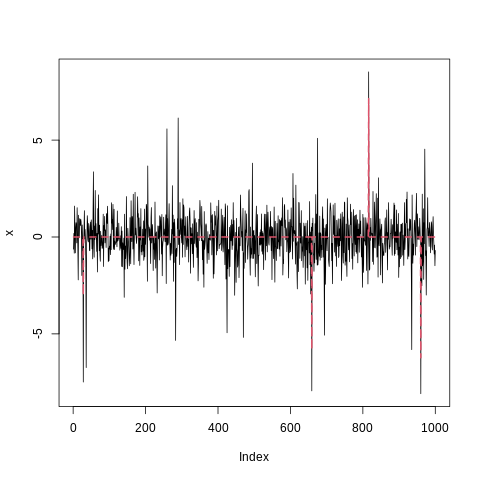

In [5]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
plot(x,type='l')
mu <- EbayesThresh::ebayesthresh(x,sdev=2)
lines(mu,col=2,lty=2,lwd=2)

### R + python

`-` R환경에 있던 x를 가지고 오기

In [6]:
%R -o x 

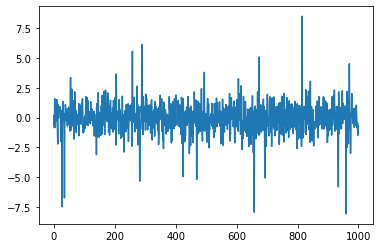

In [7]:
plt.plot(x)

`-` R환경에 있는 ebayesthresh 함수를 가지고 오기

In [8]:
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [9]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [10]:
xhat = np.array(ebayesthresh(FloatVector(x)))

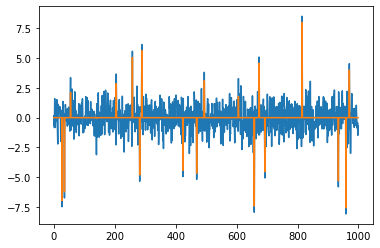

In [11]:
plt.plot(x)
plt.plot(xhat)

## 시도 1

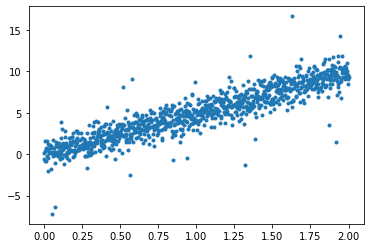

In [12]:
_x = np.linspace(0,2,1000)
_y = 5*_x  + x # x is epsilon
plt.plot(_x,_y,'.')

In [13]:
df1=pd.DataFrame({'x':_x, 'y':_y})

In [14]:
w1=np.zeros((1000,1000))

In [15]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w1[i,j] = 0
        elif np.abs(i-j) <= 30 : 
            w1[i,j] = 1

In [16]:
class SIMUL:
    def __init__(self,df1):
        self.df = df1 
        self.y = df1.y.to_numpy()
        self.x = df1.x.to_numpy()
        self.n = len(self.y)
        self.W = w1
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=2))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        plt.plot(self.x,self.y,'.')
        plt.plot(self.x,self.yhat,'--')

In [17]:
_simul = SIMUL(df1)

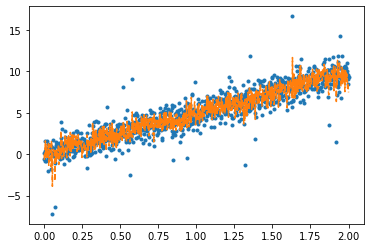

In [18]:
_simul.fit2()

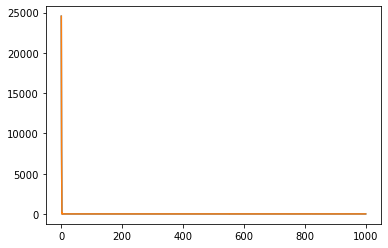

In [19]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

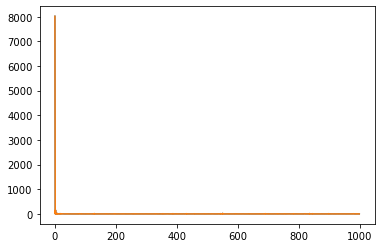

In [20]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

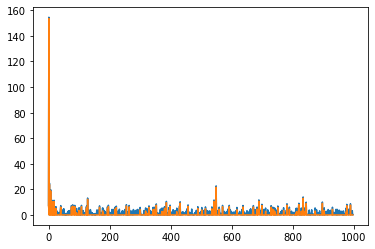

In [21]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [22]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,-0.014191,-0.612263
1,0.002002,0.193653,-0.714081,0.907734
2,0.004004,-0.815609,-0.375017,-0.440592
3,0.006006,1.625311,0.700478,0.924833
4,0.008008,0.369548,1.614271,-1.244723
...,...,...,...,...
995,1.991992,9.646667,9.031589,0.615078
996,1.993994,9.089299,8.000757,1.088542
997,1.995996,9.560693,8.595322,0.965371
998,1.997998,8.507238,8.035880,0.471358


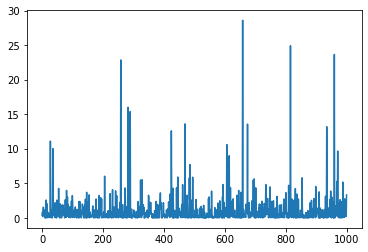

In [23]:
plt.plot((_simul.df.Residual)**2)

## 시도 2

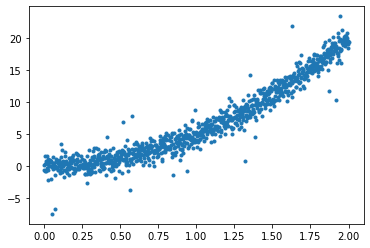

In [24]:
_x = np.linspace(0,2,1000)
_y = 5*_x**2  + x # x is epsilon
plt.plot(_x,_y,'.')

In [25]:
df2=pd.DataFrame({'x':_x, 'y':_y})

In [26]:
w2 =np.zeros((1000,1000))

In [27]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w2[i,j] = 0
        elif np.abs(i-j) <= 30 : 
            w2[i,j] = 1

In [28]:
class SIMUL:
    def __init__(self,df2):
        self.df = df2 
        self.y = df2.y.to_numpy()
        self.x = df2.x.to_numpy()
        self.n = len(self.y)
        self.W = w2
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=2))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        plt.plot(self.x,self.y,'.')
        plt.plot(self.x,self.yhat,'--')

In [29]:
_simul = SIMUL(df2)

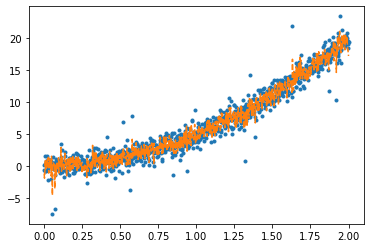

In [30]:
_simul.fit2()

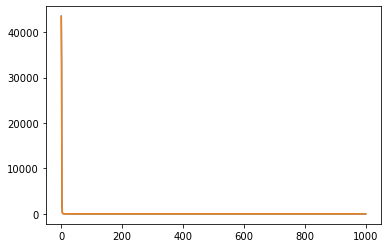

In [31]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

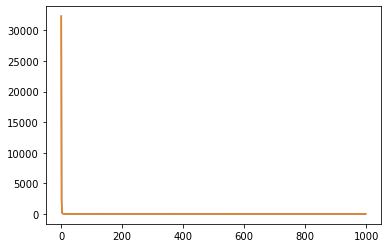

In [32]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

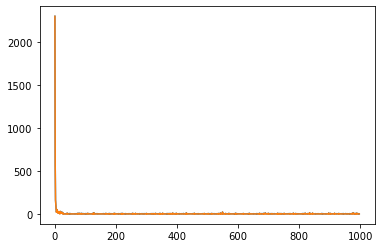

In [33]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [34]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,-1.167412,0.540959
1,0.002002,0.183663,-1.888650,2.072314
2,0.004004,-0.835548,-1.499371,0.663822
3,0.006006,1.595461,0.248074,1.347387
4,0.008008,0.329828,1.025210,-0.695381
...,...,...,...,...
995,1.991992,19.526868,19.197196,0.329672
996,1.993994,18.999390,18.194349,0.805040
997,1.995996,19.500713,18.204300,1.296413
998,1.997998,18.477228,17.750788,0.726441


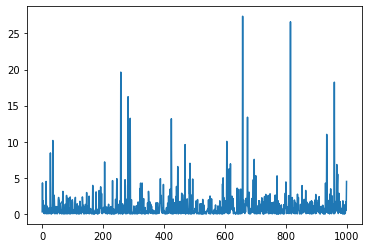

In [35]:
plt.plot((_simul.df.Residual)**2)

## 시도 3

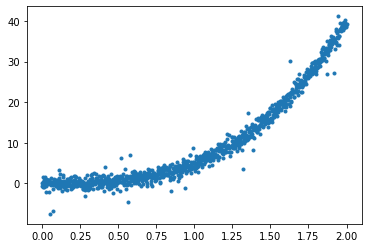

In [36]:
_x = np.linspace(0,2,1000)
_y = 5*_x**3  + x # x is epsilon
plt.plot(_x,_y,'.')

In [37]:
df3=pd.DataFrame({'x':_x, 'y':_y})

In [38]:
w3 =np.zeros((1000,1000))

In [39]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w3[i,j] = 0
        elif np.abs(i-j) <= 30 : 
            w3[i,j] = 1

In [40]:
class SIMUL:
    def __init__(self,df3):
        self.df = df3 
        self.y = df3.y.to_numpy()
        self.x = df3.x.to_numpy()
        self.n = len(self.y)
        self.W = w3
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=2))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        plt.plot(self.x,self.y,'.')
        plt.plot(self.x,self.yhat,'--')

In [41]:
_simul = SIMUL(df3)

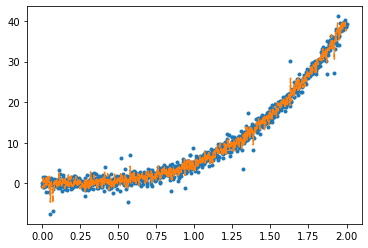

In [42]:
_simul.fit2()

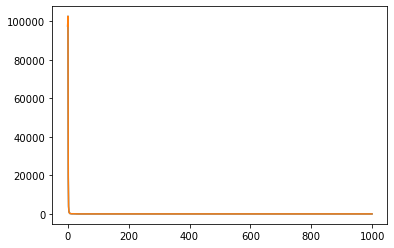

In [43]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

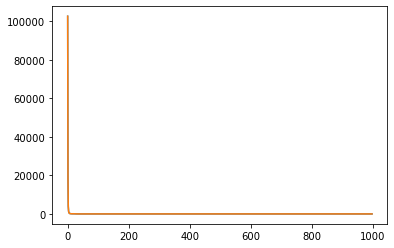

In [44]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

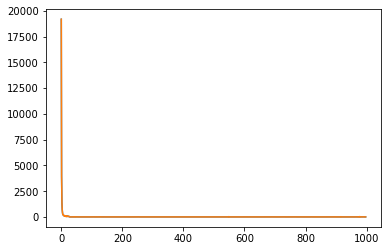

In [45]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [46]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,-0.586540,-0.039914
1,0.002002,0.183643,-1.174825,1.358469
2,0.004004,-0.835628,-1.197781,0.362153
3,0.006006,1.595282,0.423024,1.172258
4,0.008008,0.329510,1.418560,-1.089050
...,...,...,...,...
995,1.991992,39.208148,38.882371,0.325777
996,1.993994,38.760050,37.807530,0.952520
997,1.995996,39.340954,38.011839,1.329115
998,1.997998,38.397248,37.731929,0.665319


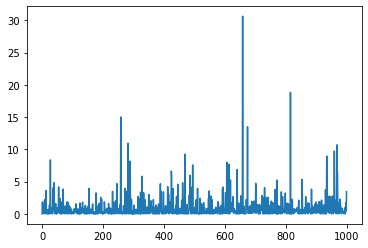

In [47]:
plt.plot((_simul.df.Residual)**2)

## 시도 4

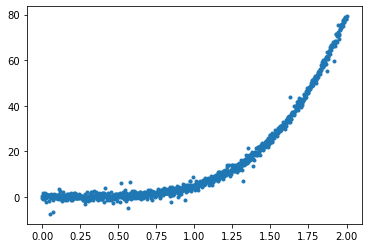

In [48]:
_x = np.linspace(0,2,1000)
_y = 5*_x**4  + x # x is epsilon
plt.plot(_x,_y,'.')

In [49]:
df4=pd.DataFrame({'x':_x, 'y':_y})

In [50]:
w4 =np.zeros((1000,1000))

In [51]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w4[i,j] = 0
        elif np.abs(i-j) <= 30 : 
            w4[i,j] = 1

In [52]:
class SIMUL:
    def __init__(self,df4):
        self.df = df4 
        self.y = df4.y.to_numpy()
        self.x = df4.x.to_numpy()
        self.n = len(self.y)
        self.W = w4
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=2))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        plt.plot(self.x,self.y,'.')
        plt.plot(self.x,self.yhat,'--')

In [53]:
_simul = SIMUL(df4)

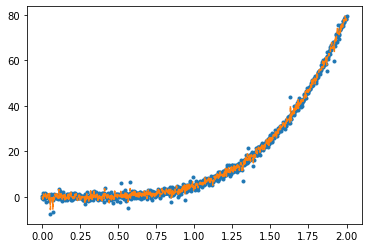

In [54]:
_simul.fit2()

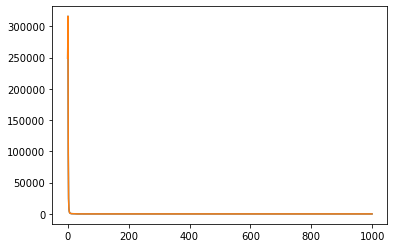

In [55]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

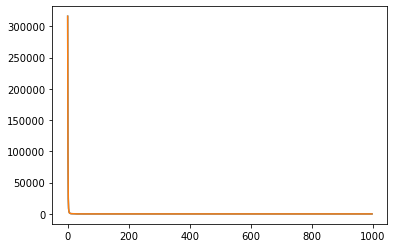

In [56]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

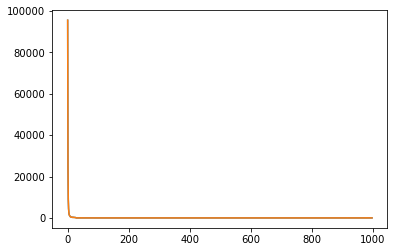

In [57]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [58]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,0.199188,-0.825642
1,0.002002,0.183643,-0.427596,0.611240
2,0.004004,-0.835629,-1.050531,0.214902
3,0.006006,1.595281,0.773646,0.821635
4,0.008008,0.329508,1.238332,-0.908825
...,...,...,...,...
995,1.991992,78.413101,78.234935,0.178166
996,1.993994,78.162688,77.558237,0.604451
997,1.995996,78.941994,78.427024,0.514970
998,1.997998,78.197409,78.671198,-0.473790


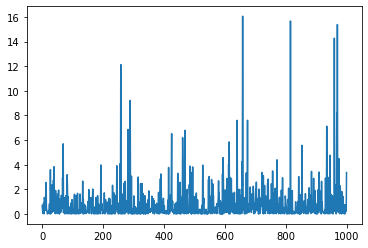

In [59]:
plt.plot((_simul.df.Residual)**2)

## 시도 5

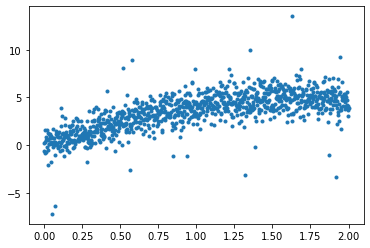

In [60]:
_x = np.linspace(0,2,1000)
_y = 5*np.sin(_x)  + x # x is epsilon
plt.plot(_x,_y,'.')

In [61]:
df5=pd.DataFrame({'x':_x, 'y':_y})

In [62]:
w5 =np.zeros((1000,1000))

In [63]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w5[i,j] = 0
        elif np.abs(i-j) <= 30 : 
            w5[i,j] = 1

In [64]:
class SIMUL:
    def __init__(self,df5):
        self.df = df5 
        self.y = df5.y.to_numpy()
        self.x = df5.x.to_numpy()
        self.n = len(self.y)
        self.W = w5
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=2.5))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        plt.plot(self.x,self.y,'.')
        plt.plot(self.x,self.yhat,'--')

In [65]:
_simul = SIMUL(df5)

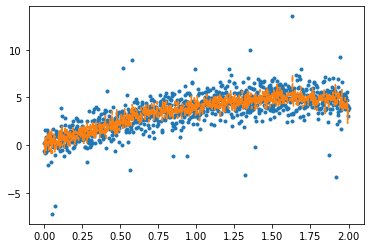

In [66]:
_simul.fit2()

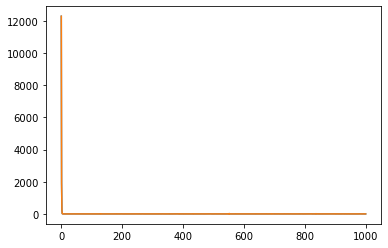

In [67]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

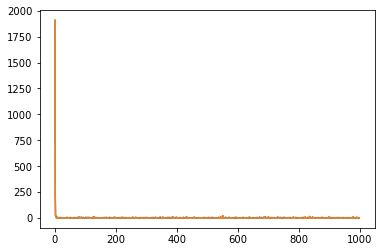

In [68]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

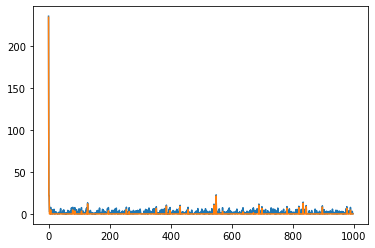

In [69]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [70]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,0.378042,-1.004496
1,0.002002,0.193653,-0.532452,0.726105
2,0.004004,-0.815609,-0.921907,0.106298
3,0.006006,1.625311,0.350420,1.274890
4,0.008008,0.369547,0.787431,-0.417884
...,...,...,...,...
995,1.991992,4.249711,4.667470,-0.417759
996,1.993994,3.678231,2.277069,1.401162
997,1.995996,4.135495,3.858072,0.277423
998,1.997998,3.067892,3.423987,-0.356095


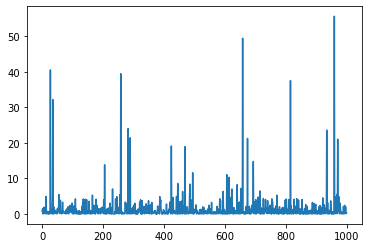

In [71]:
plt.plot((_simul.df.Residual)**2)

## 시도 6

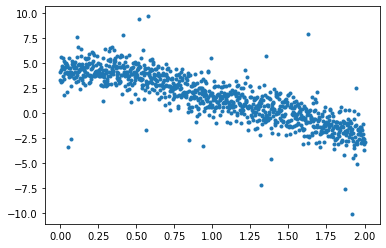

In [72]:
_x = np.linspace(0,2,1000)
_y =  3*np.cos(_x) + 1*np.cos(_x**2) + 0.5*np.sin(5*_x)  + x # x is epsilon
plt.plot(_x,_y,'.')

In [73]:
df6=pd.DataFrame({'x':_x, 'y':_y})

In [74]:
w6 =np.zeros((1000,1000))

In [75]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w6[i,j] = 0
        elif np.abs(i-j) <= 30 : 
            w6[i,j] = 1

In [76]:
class SIMUL:
    def __init__(self,df6):
        self.df = df6 
        self.y = df6.y.to_numpy()
        self.x = df6.x.to_numpy()
        self.n = len(self.y)
        self.W = w6
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=2.5))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        plt.plot(self.x,self.y,'.')
        plt.plot(self.x,self.yhat,'--')

In [77]:
_simul = SIMUL(df6)

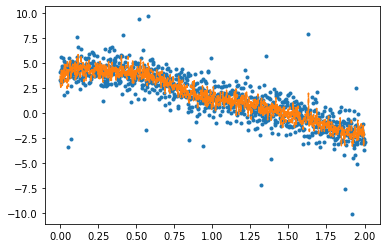

In [78]:
_simul.fit2()

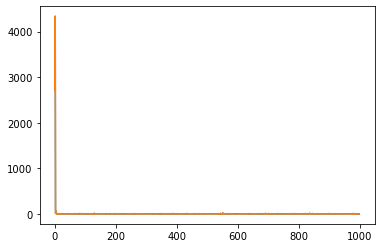

In [79]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

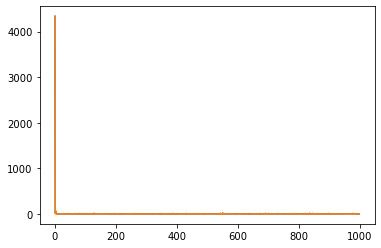

In [80]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

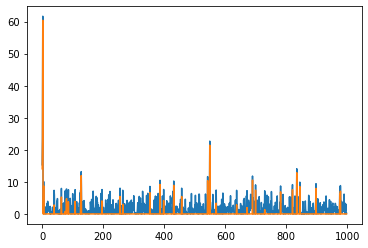

In [81]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [82]:
_simul.df

,x,y,yHat,Residual
0,0.000000,3.373546,3.784442,-0.410896
1,0.002002,4.188642,2.904502,1.284140
2,0.004004,3.174357,2.611149,0.563208
3,0.006006,5.610239,3.949581,1.660659
4,0.008008,4.349426,4.317214,0.032212
...,...,...,...,...
995,1.991992,-2.472346,-1.039245,-1.433101
996,1.993994,-3.043604,-3.302926,0.259322
997,1.995996,-2.586021,-1.713172,-0.872849
998,1.997998,-3.653206,-2.155795,-1.497411


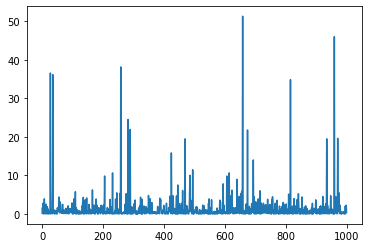

In [83]:
plt.plot((_simul.df.Residual)**2)

## 시도 7

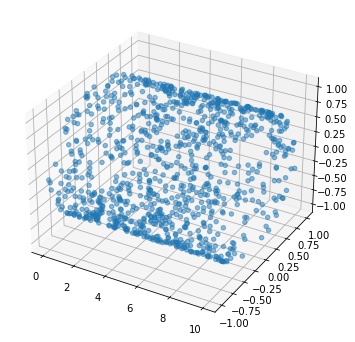

In [84]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
_x = np.linspace(0,10,1000)
_y = np.sin(5*x)
_z = np.cos(5*x) 
ax.scatter(_x, _y, _z,alpha = 0.5)

In [85]:
df7=pd.DataFrame({'x':_x, 'y':_y, 'z':_z})

In [86]:
w7 =np.zeros((1000,1000))

In [87]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w7[i,j] = 0
        elif np.abs(i-j) <= 30 : 
            w7[i,j] = 1

In [116]:
class SIMUL:
    def __init__(self,df7):
        self.df = df7
        self.z = df7.z.to_numpy()
        self.y = df7.y.to_numpy()
        self.x = df7.x.to_numpy()
        self.n = len(self.y)
        self.W = w7
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power_ybar = self.ybar**2 
        self.power_threshed_ybar=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=2))
        self.ybar_threshed = np.where(self.power_threshed_ybar>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
                
        self.zbar = self.Psi.T @ self.z # fbar := graph fourier transform of f
        self.power_zbar = self.zbar**2 
        self.power_threshed_zbar=np.array(ebayesthresh(FloatVector(self.zbar**2),sd=2))
        self.zbar_threshed = np.where(self.power_threshed_zbar>0,self.zbar,0)
        self.zhat = self.Psi@self.zbar_threshed
        
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual_y = self.df.y- self.df.yHat)
        self.df = self.df.assign(zHat = self.zhat)
        self.df = self.df.assign(Residual_z = self.df.z- self.df.zHat)
        
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.x, self.y, self.z,alpha = 0.5)
        ax.scatter(self.x, self.yhat, self.zhat,alpha = 0.5)

In [117]:
_simul = SIMUL(df7)

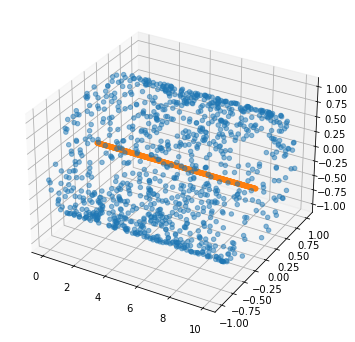

In [118]:
_simul.fit2()

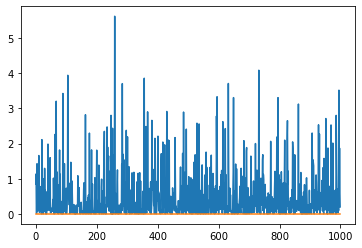

In [119]:
plt.plot(_simul.power_ybar)
plt.plot(_simul.power_threshed_ybar)

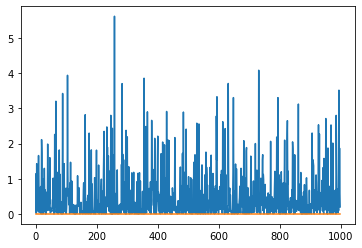

In [92]:
plt.plot(_simul.power_ybar[1:])
plt.plot(_simul.power_threshed_ybar[1:])

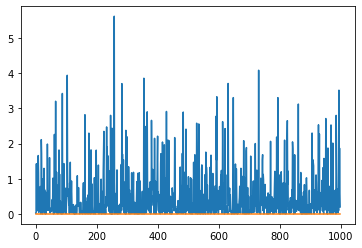

In [93]:
plt.plot(_simul.power_ybar[2:])
plt.plot(_simul.power_threshed_ybar[2:])

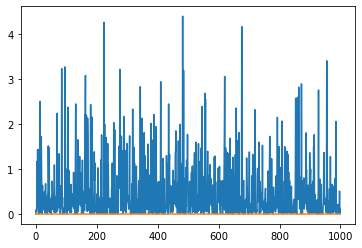

In [94]:
plt.plot(_simul.power_zbar)
plt.plot(_simul.power_threshed_zbar)

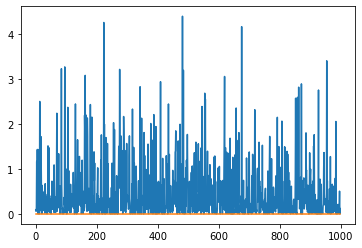

In [95]:
plt.plot(_simul.power_zbar[1:])
plt.plot(_simul.power_threshed_zbar[1:])

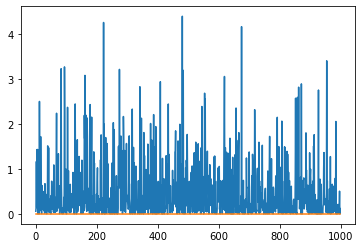

In [96]:
plt.plot(_simul.power_zbar[2:])
plt.plot(_simul.power_threshed_zbar[2:])

In [97]:
_simul.df

,x,y,z,yHat,Residual_y,zHat,Residual_z
0,0.00000,-0.009323,-0.999957,0.0,-0.009323,0.0,-0.999957
1,0.01001,0.794520,0.607238,0.0,0.794520,0.0,0.607238
2,0.02002,0.860653,-0.509192,0.0,0.860653,0.0,-0.509192
3,0.03003,0.992516,-0.122117,0.0,0.992516,0.0,-0.122117
4,0.04004,0.997057,-0.076667,0.0,0.997057,0.0,-0.076667
...,...,...,...,...,...,...,...
995,9.95996,-0.999991,0.004332,0.0,-0.999991,0.0,0.004332
996,9.96997,0.952627,-0.304140,0.0,0.952627,0.0,-0.304140
997,9.97998,-0.865004,-0.501765,0.0,-0.865004,0.0,-0.501765
998,9.98999,-0.904657,0.426141,0.0,-0.904657,0.0,0.426141


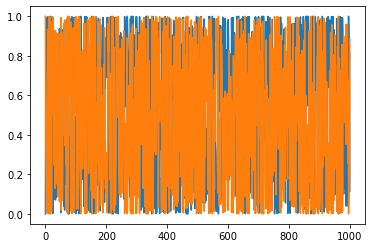

In [98]:
plt.plot((_simul.df.Residual_y)**2)
plt.plot((_simul.df.Residual_z)**2)

## 시도 8

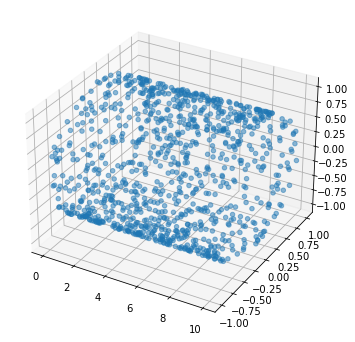

In [99]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
_x = np.linspace(0,10,1000)
_y = np.sin(20*x)
_z = np.cos(20*x) 
ax.scatter(_x, _y, _z,alpha = 0.5)

In [100]:
df8=pd.DataFrame({'x':_x, 'y':_y, 'z':_z})

In [101]:
w8 =np.zeros((1000,1000))

In [102]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w8[i,j] = 0
        elif np.abs(i-j) <= 30 : 
            w8[i,j] = 1

In [103]:
class SIMUL:
    def __init__(self,df8):
        self.df = df8 
        self.z = df8.z.to_numpy()
        self.y = df8.y.to_numpy()
        self.x = df8.x.to_numpy()
        self.n = len(self.y)
        self.W = w8
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power_ybar = self.ybar**2 
        self.power_threshed_ybar=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=2))
        self.ybar_threshed = np.where(self.power_threshed_ybar>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
                
        self.zbar = self.Psi.T @ self.z # fbar := graph fourier transform of f
        self.power_zbar = self.zbar**2 
        self.power_threshed_zbar=np.array(ebayesthresh(FloatVector(self.zbar**2),sd=2))
        self.zbar_threshed = np.where(self.power_threshed_zbar>0,self.zbar,0)
        self.zhat = self.Psi@self.zbar_threshed
        
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual_y = self.df.y- self.df.yHat)
        self.df = self.df.assign(zHat = self.zhat)
        self.df = self.df.assign(Residual_z = self.df.z- self.df.zHat)
        
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.x, self.y, self.z,alpha = 0.5)
        ax.scatter(self.x, self.yhat, self.zhat,alpha = 0.5)

In [104]:
_simul = SIMUL(df8)

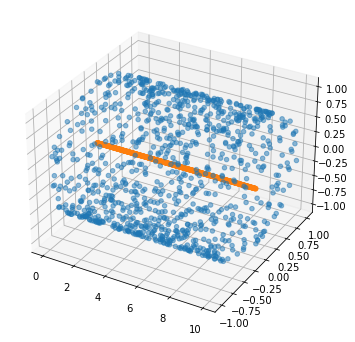

In [105]:
_simul.fit2()

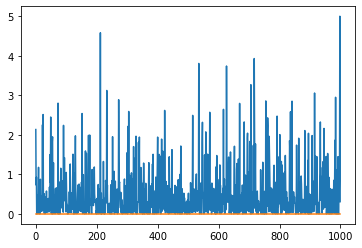

In [106]:
plt.plot(_simul.power_ybar)
plt.plot(_simul.power_threshed_ybar)

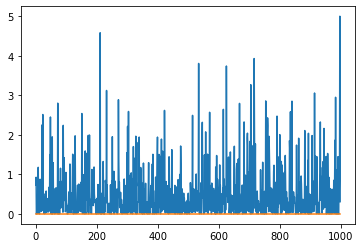

In [107]:
plt.plot(_simul.power_ybar[1:])
plt.plot(_simul.power_threshed_ybar[1:])

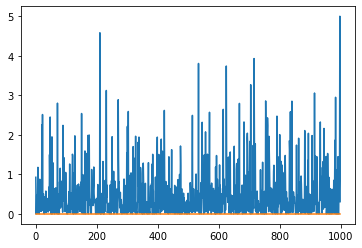

In [108]:
plt.plot(_simul.power_ybar[2:])
plt.plot(_simul.power_threshed_ybar[2:])

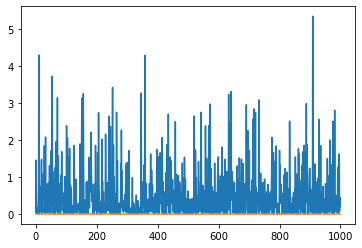

In [109]:
plt.plot(_simul.power_zbar)
plt.plot(_simul.power_threshed_zbar)

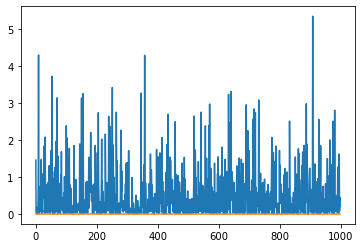

In [110]:
plt.plot(_simul.power_zbar[1:])
plt.plot(_simul.power_threshed_zbar[1:])

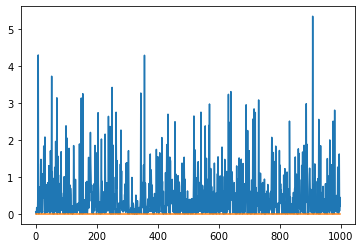

In [111]:
plt.plot(_simul.power_zbar[2:])
plt.plot(_simul.power_threshed_zbar[2:])

In [112]:
_simul.df

,x,y,z,yHat,Residual_y,zHat,Residual_z
0,0.00000,0.037286,0.999305,0.0,0.037286,0.0,0.999305
1,0.01001,-0.506632,-0.862162,0.0,-0.506632,0.0,-0.862162
2,0.02002,0.843952,-0.536418,0.0,0.843952,0.0,-0.536418
3,0.03003,0.470352,0.882479,0.0,0.470352,0.0,0.882479
4,0.04004,0.302172,0.953253,0.0,0.302172,0.0,0.953253
...,...,...,...,...,...,...,...
995,9.95996,0.017327,0.999850,0.0,0.017327,0.0,0.999850
996,9.96997,0.944524,0.328443,0.0,0.944524,0.0,0.328443
997,9.97998,-0.861918,-0.507048,0.0,-0.861918,0.0,-0.507048
998,9.98999,0.981986,-0.188954,0.0,0.981986,0.0,-0.188954


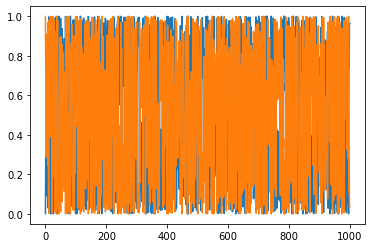

In [113]:
plt.plot((_simul.df.Residual_y)**2)
plt.plot((_simul.df.Residual_z)**2)

---